<h2>Script TP2</h2>
<h3>Assumptions Check</h3>
<h3>Path analysis</h3>
<br> (c) Marie-Eve Picard, Maude Picard, Andreanne Proulx

<h3>Assumptions Check</h3>
<h4>Normality, multicollinearity, singularity</h4>

In [1]:
#import required modules
import pandas as pd 
import numpy as np
import scipy
import scipy.stats as stats
import math
import matplotlib
from matplotlib import pyplot as plt 
%matplotlib inline
import seaborn as sn
import statsmodels.api as sm
from sklearn import preprocessing

import biokit
from biokit.viz import corrplot
import seaborn as sns
from biokit.viz import heatmap
import dcor
import copy
import graphviz

import semopy
from semopy import Model
from semopy import semplot
import graphviz
from graphviz import Digraph
from graphviz import Graph
from graphviz import escape
import semopy

In [2]:
#set pandas option so that we can see the entire dataframe
pd.set_option("display.max_rows", None, "display.max_columns", None)

<b>Import the dataset</b>

In [3]:
#Value labels have been remove directly from SPSS using the syntaxe:
#VALUE LABELS ALL

In [4]:
#df = pd.read_spss("C:/Users/mepic/OneDrive/Documents/Master/PSY6002/TP/TP2/PSY6002_Cannabis_removeLabels.sav")
df = pd.read_csv("data_tp2.csv", sep= ";")

## Prepare data

- Remove demographic variables
- Regroup variables T1, T2, T3

In [5]:
#Variables to exclude
ls_excluded = ['respid','status','l','version','dwave','Consent','XAge','Birth','XBirth','Mom_Nat','XMom_Nat', 'Pop_Nat', 'XPop_Nat', 'Country', 'Province','City','XCity','Language','XLanguage','French','English','Nationality','CanNat','OtherNat','Can_Qc','Diploma','Situation','FinalComments','ConsentT2','FinalCommentsT2','ConsentT3','FinalCommentT3','oldq1','oldl','oldhq2','oldq9','oldCountryBirth','oldMotherBirth','oldDadBirth','oldCountry','oleProvince','OldNationality','oleDiploma','oldq11','IdenGroupT2','oldAge', 'IdenGroupT3']
df = df.drop(ls_excluded, axis = 1)

In [6]:
#Regroup variables with a spectific substring in the name
def regroupVar(substr=None, liste=None):
    subs = substr
    res = [i for i in liste if subs in i]
    return res


columns_T2 = regroupVar(substr = 'T2', liste = df.columns)
columns_T3 = regroupVar(substr = 'T3', liste = df.columns)

In [7]:
#Create new Dataframes with variables at different times (T1, T2, T3)
df_T1 = df.drop(columns_T2+columns_T3, axis = 1)
df_T2 = df.filter(items = columns_T2)
df_T3 = df.filter(items = columns_T3)

In [8]:
df_T1.columns

Index(['Gender', 'Age', 'life_cond', 'left_right', 'change_trad', 'Freqnow',
       'Userstatus', 'Legal', 'Illegal', 'Quantity', 'Frequency', 'Attitude_2',
       'Attitude_3', 'Attitude_4', 'GQuantity', 'GFrequency', 'Neg_Pos',
       'AffectPerso', 'AffectGroup', 'Rapid_slow', 'Few_Many', 'Small_Big',
       'Comp_1', 'Comp_2', 'Cat', 'Int_2', 'Int_3', 'Int_4', 'IdentifyPot',
       'CommonPot', 'ImpPot', 'Moi_Pot', 'GComp_1', 'GComp_2', 'GCat',
       'GInt_2', 'GInt_3', 'GInt_4', 'GIdentifyPot', 'GcommonPot', 'GImpPot',
       'Can_Pot', 'Qc_Pot', 'SuiviPot', 'Clarity_2', 'Clarity_3',
       'Coherence_1', 'Coherence_3', 'Coherence_4', 'Belong_1', 'Belong_2',
       'Belong_3', 'Safety_1', 'Safety_2', 'Safety_3', 'Comp', 'GComp',
       'IdenPot', 'GIdenPot', 'Attitudes', 'Int', 'GInt', 'Clarity',
       'Coherence', 'Belong', 'Safety'],
      dtype='object')

<h3><b>Transform Userstatus variable in a dichotomous variable</h3></b>
<br> 0 = jamais consommé (category included: Non-consommateur)
<br>1 = déjà consommé (categories included: Ex-consommateur, Expérimentateur, Occasionnel, Régulier)

In [9]:
df_T1['UserBin'] = ""
for i in range(len(df_T1['Userstatus'])):
    if df_T1['Userstatus'][i] == 1.0:
        df_T1['UserBin'][i] = 0
    else:
        df_T1['UserBin'][i] = 1

df_T1['UserBin'] = df_T1['UserBin'].astype('category')

/home/anproulx/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/anproulx/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<h3><b>Compute variables</h3></b>

<b>Compute the Attitude variable (T1)</b>
<br>reverse attitude items and compute the mean

In [10]:
#Create dataframe with only variables from prejudice scale
att_scale_T1 = df_T1.filter(items = ['Attitude_2','Attitude_3','Attitude_4'])

In [11]:
#Create a function to reverse the score
def inversed_score(dataframe = None, high = None):
    dataframe_dummy = dataframe.copy()
    for i in range(len(dataframe_dummy.columns)):
        for j in range (len(dataframe_dummy[dataframe_dummy.columns[0]])):
            dataframe_dummy[dataframe_dummy.columns[i]][j] = high - dataframe_dummy[dataframe_dummy.columns[i]][j]

    return dataframe_dummy

In [12]:
#Reverse Echelle de prejuges
att_scale_T1_inversed = inversed_score(dataframe = att_scale_T1, high = 4)

In [13]:
#Compute the mean of items in Echelle de prejuges (items 19 a 22)
df_T1["att_mean"] = att_scale_T1_inversed.mean(axis=1, skipna=False)

In [14]:
def compute_mean(dataframe=None, cols = None, col_name = None):
    dataframe[col_name] = dataframe[cols].mean(axis = 1)

    return dataframe

In [15]:
# string -> float 
columns = df_T1.columns
for column in columns:
    if type(df_T1[column][0]) == str:
        
        df_T1[column] = df_T1[column].apply(lambda x: str(x.replace(',','.')))
        df_T1[column]= pd.to_numeric(df_T1[column], errors='coerce')

df_T1.head()

,Gender,Age,life_cond,left_right,change_trad,Freqnow,Userstatus,Legal,Illegal,Quantity,Frequency,Attitude_2,Attitude_3,Attitude_4,GQuantity,GFrequency,Neg_Pos,AffectPerso,AffectGroup,Rapid_slow,Few_Many,Small_Big,Comp_1,Comp_2,Cat,Int_2,Int_3,Int_4,IdentifyPot,CommonPot,ImpPot,Moi_Pot,GComp_1,GComp_2,GCat,GInt_2,GInt_3,GInt_4,GIdentifyPot,GcommonPot,GImpPot,Can_Pot,Qc_Pot,SuiviPot,Clarity_2,Clarity_3,Coherence_1,Coherence_3,Coherence_4,Belong_1,Belong_2,Belong_3,Safety_1,Safety_2,Safety_3,Comp,GComp,IdenPot,GIdenPot,Attitudes,Int,GInt,Clarity,Coherence,Belong,Safety,UserBin,att_mean
0,1,55.0,2,2,4,1,1,0,0,2,2,3,3,2,4,4,0,3,3,3,1,4,3,2,4,2,2,2,0,0,0,1,4,2,2,2,2,2,2,2,2,1,1,4,2,2,2,2,2,4,2,4,4,3,3,2.5,3.0,0.0,2.000000,2.666667,2.000000,2.0,2.0,2.000000,3.333333,3.333333,0,1.333333
1,2,71.0,3,2,3,1,1,2,0,1,1,0,1,1,3,3,2,2,3,3,2,2,2,2,1,0,0,0,0,0,0,1,3,3,3,0,0,0,1,2,0,1,1,2,3,3,3,1,2,4,3,4,4,4,4,2.0,3.0,0.0,1.000000,0.666667,0.000000,0.0,3.0,2.000000,3.666667,4.000000,0,3.333333
2,2,37.0,2,2,3,1,1,0,0,2,2,1,3,3,4,4,2,1,2,1,2,2,2,4,4,4,4,4,0,0,0,1,3,3,3,3,3,3,3,3,1,4,7,0,1,2,2,3,2,4,4,4,4,4,4,3.0,3.0,0.0,2.333333,2.333333,4.000000,3.0,1.5,2.333333,4.000000,4.000000,0,1.666667
3,2,66.0,2,2,2,1,3,0,0,2,2,2,4,2,4,4,1,0,0,0,3,2,0,2,4,3,3,2,0,0,0,1,4,4,4,1,1,1,2,2,0,1,1,2,1,3,1,1,0,2,2,3,3,3,3,1.0,4.0,0.0,1.333333,2.666667,2.666667,1.0,2.0,0.666667,2.333333,3.000000,1,1.333333
4,2,53.0,1,2,2,1,1,2,2,2,2,2,2,2,2,2,2,1,3,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2.0,2.0,2.0,2.000000,2.000000,2.000000,2.0,2.0,2.000000,2.000000,2.000000,0,2.000000


In [16]:
#Compute perception du changement social (items 27,28,29,29)
df_T1 = compute_mean(dataframe = df_T1, cols = ['AffectGroup', 'Rapid_slow', 'Few_Many', 'Small_Big'], col_name = 'perc_soc')
#Compute clarity and coherence (items 46 a 52)
df_T1 = compute_mean(dataframe = df_T1, cols = ['Clarity','Coherence'], col_name = 'clar_co')
#Compute Besoin (items 53  a 60)
df_T1 = compute_mean(dataframe = df_T1, cols = ['Belong','Safety'], col_name = 'need')
#Compute perception (items 23, 24)
df_T1 = compute_mean(dataframe = df_T1, cols = ['GQuantity', 'GFrequency'], col_name = 'percep')

In [17]:
df_T1.columns

Index(['Gender', 'Age', 'life_cond', 'left_right', 'change_trad', 'Freqnow',
       'Userstatus', 'Legal', 'Illegal', 'Quantity', 'Frequency', 'Attitude_2',
       'Attitude_3', 'Attitude_4', 'GQuantity', 'GFrequency', 'Neg_Pos',
       'AffectPerso', 'AffectGroup', 'Rapid_slow', 'Few_Many', 'Small_Big',
       'Comp_1', 'Comp_2', 'Cat', 'Int_2', 'Int_3', 'Int_4', 'IdentifyPot',
       'CommonPot', 'ImpPot', 'Moi_Pot', 'GComp_1', 'GComp_2', 'GCat',
       'GInt_2', 'GInt_3', 'GInt_4', 'GIdentifyPot', 'GcommonPot', 'GImpPot',
       'Can_Pot', 'Qc_Pot', 'SuiviPot', 'Clarity_2', 'Clarity_3',
       'Coherence_1', 'Coherence_3', 'Coherence_4', 'Belong_1', 'Belong_2',
       'Belong_3', 'Safety_1', 'Safety_2', 'Safety_3', 'Comp', 'GComp',
       'IdenPot', 'GIdenPot', 'Attitudes', 'Int', 'GInt', 'Clarity',
       'Coherence', 'Belong', 'Safety', 'UserBin', 'att_mean', 'perc_soc',
       'clar_co', 'need', 'percep'],
      dtype='object')

<b>Create a dataframe with the computed variables</b>

In [18]:
ls_excluded_T1 = ['Attitude_2','Attitude_3', 'Attitude_4', 'Attitudes','GQuantity','GFrequency','AffectGroup', 'Rapid_slow', 'Few_Many', 'Small_Big', 'Comp_1', 'Comp_2', 'Int_2', 'Int_3', 'Int_4', 'IdentifyPot','CommonPot', 'ImpPot', 'GComp_1', 'GComp_2', 'GInt_2', 'GInt_3', 'GInt_4', 'GIdentifyPot', 'GcommonPot', 'GImpPot', 'Clarity_2', 'Clarity_3','Coherence_1', 'Coherence_3', 'Coherence_4', 'Belong_1', 'Belong_2','Belong_3', 'Safety_1', 'Safety_2', 'Safety_3','Clarity','Coherence', 'Belong', 'Safety']

In [19]:
df_T1 = df_T1.drop(ls_excluded_T1, axis = 1)

In [20]:
#Change type of categorical variables (now they are consider as continuous variables)
df_T1['Freqnow'] = df_T1['Freqnow'].astype('category')
df_T1['Userstatus'] = df_T1['Userstatus'].astype('category')
df_T1['Legal'] = df_T1['Legal'].astype('category')
df_T1['Illegal'] = df_T1['Illegal'].astype('category')
df_T1['Quantity'] = df_T1['Quantity'].astype('category')
df_T1['Frequency'] = df_T1['Frequency'].astype('category')

## Data exploration


<h3><b>Correlation Matrix</b></h3>
The correlation matrix was computed in order to build our model

In [21]:
#Exclude missing values
#df_T1 = df_T1.dropna()
df_T1.head()

,Gender,Age,life_cond,left_right,change_trad,Freqnow,Userstatus,Legal,Illegal,Quantity,Frequency,Neg_Pos,AffectPerso,Cat,Moi_Pot,GCat,Can_Pot,Qc_Pot,SuiviPot,Comp,GComp,IdenPot,GIdenPot,Int,GInt,UserBin,att_mean,perc_soc,clar_co,need,percep
0,1,55.0,2,2,4,1,1,0,0,2,2,0,3,4,1,2,1,1,4,2.5,3.0,0.0,2.000000,2.000000,2.0,0,1.333333,2.75,2.000000,3.333333,4.0
1,2,71.0,3,2,3,1,1,2,0,1,1,2,2,1,1,3,1,1,2,2.0,3.0,0.0,1.000000,0.000000,0.0,0,3.333333,2.50,2.500000,3.833333,3.0
2,2,37.0,2,2,3,1,1,0,0,2,2,2,1,4,1,3,4,7,0,3.0,3.0,0.0,2.333333,4.000000,3.0,0,1.666667,1.75,1.916667,4.000000,4.0
3,2,66.0,2,2,2,1,3,0,0,2,2,1,0,4,1,4,1,1,2,1.0,4.0,0.0,1.333333,2.666667,1.0,1,1.333333,1.25,1.333333,2.666667,4.0
4,2,53.0,1,2,2,1,1,2,2,2,2,2,1,2,1,2,2,2,2,2.0,2.0,2.0,2.000000,2.000000,2.0,0,2.000000,2.25,2.000000,2.000000,2.0


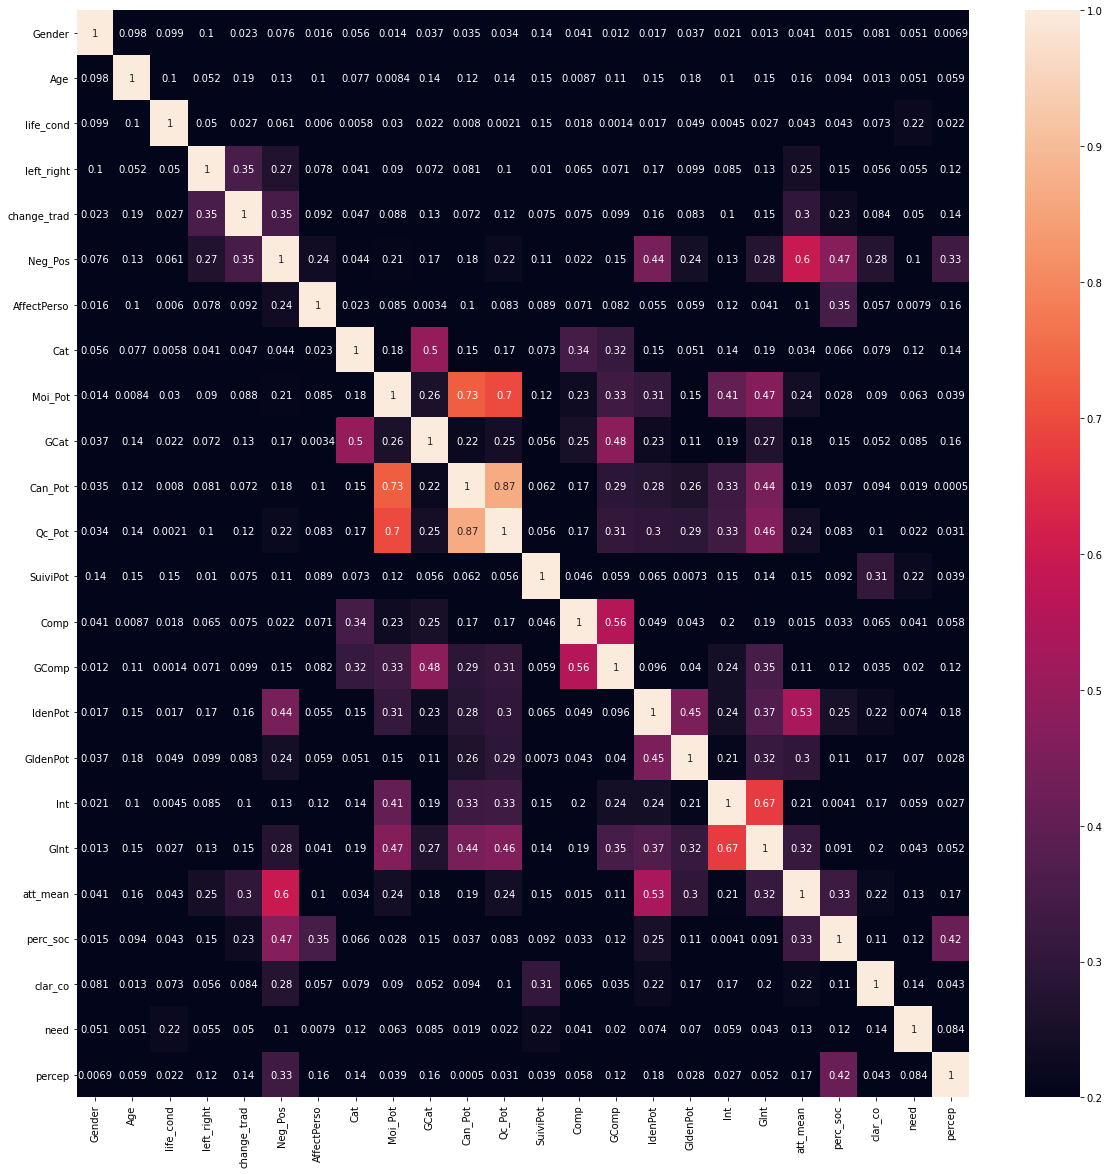

In [22]:
corr_matrix = df_T1.corr(method = 'pearson')

f, ax = plt.subplots(figsize=(20, 20))
ax = sn.heatmap(corr_matrix.abs(), annot = True, vmin=0.2, vmax=1.0)

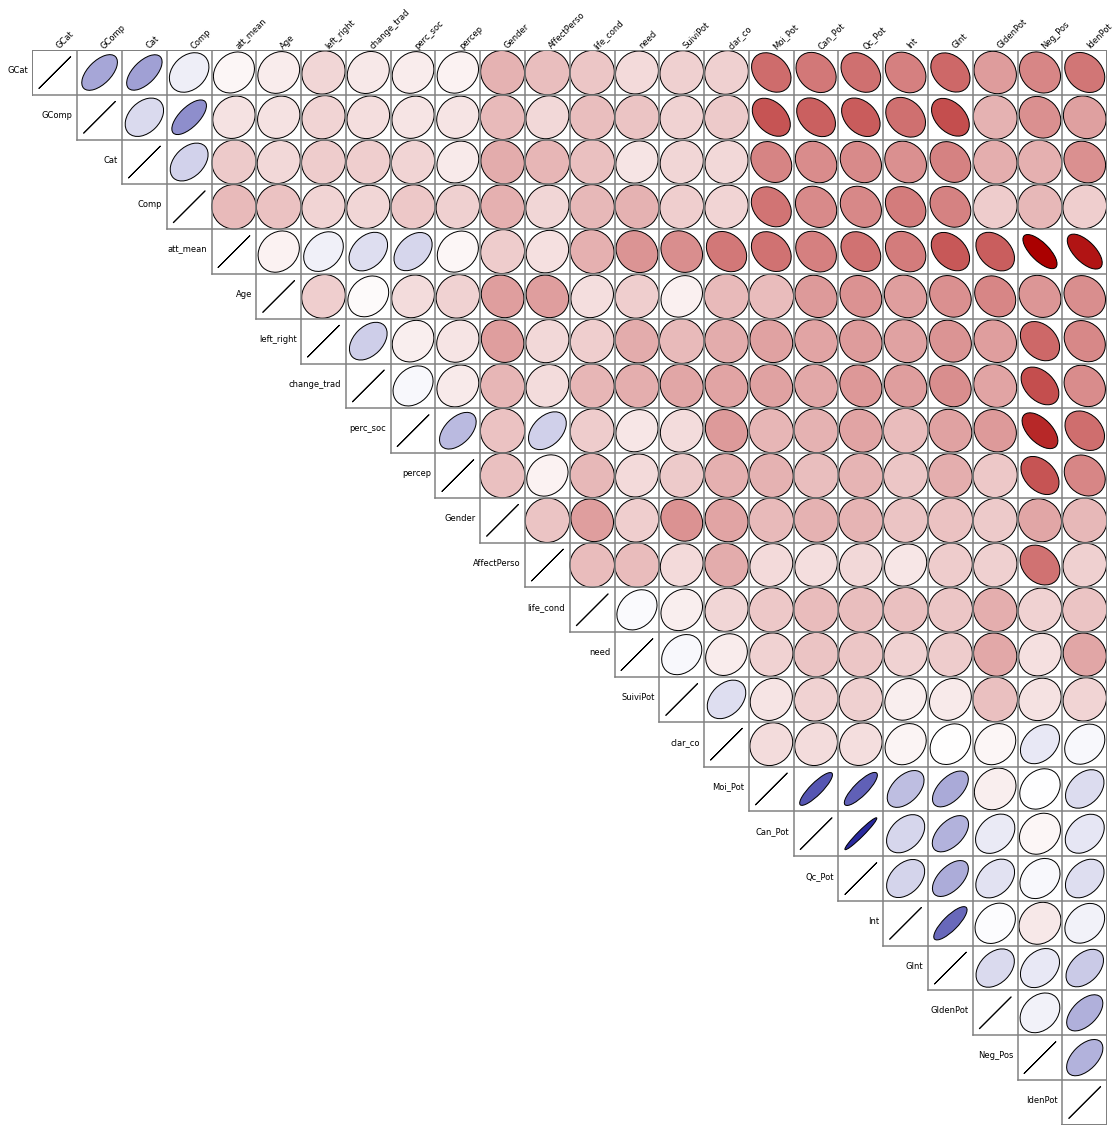

In [23]:
corr_matrix = df_T1.corr(method = 'pearson')
c = corrplot.Corrplot(corr_matrix)

c.plot(colorbar=False, method='text',shrink= 1 ,rotation=45, upper = "ellipse")
fig = plt.gcf()
fig.set_size_inches(20, 20)

In [29]:
#Check correlation values above 0.2 and below -0.2
#Access columns
df_corr = pd.DataFrame(columns=['Var1','Var2','Value'])
for i in range (len(corr_matrix)):
    #Access rows
    for j in range (len(corr_matrix)):
        if corr_matrix[corr_matrix.columns[i]][j] > 0.2 or corr_matrix[corr_matrix.columns[i]][j] < -0.2:
            if corr_matrix[corr_matrix.columns[i]][j] != 1:
                df_corr=df_corr.append({'Var1': corr_matrix.columns[i], 'Var2': corr_matrix.index[j], 'Value': corr_matrix[corr_matrix.columns[i]][j]}, ignore_index = True)

In [30]:
df_corr

,Var1,Var2,Value
0,life_cond,need,0.220385
1,left_right,change_trad,0.353501
2,left_right,Neg_Pos,-0.269274
3,left_right,att_mean,0.246708
4,change_trad,left_right,0.353501
5,change_trad,Neg_Pos,-0.351914
6,change_trad,att_mean,0.302912
7,change_trad,perc_soc,0.225196
8,Neg_Pos,left_right,-0.269274
9,Neg_Pos,change_trad,-0.351914


In [31]:
df_corr.to_csv('corr.csv', index=False)

<h2><b>Model Choice</h2></b>
<br>Variables included in the model: 

<li>GInt : endogene </li>
<li>GIdenPot : exogene</li>
<li>mean_att : exogene</li>
<li>Neg_pos : endogene</li>

In [32]:
data = df_T1[["GInt", "Neg_Pos", "IdenPot", "att_mean"]]

### Sample moments

In [68]:
## Sample correlation
mx_cor_initial = data.corr()

print ("Matrice de corrélations initiales \n \n" + str(mx_cor_initial))

Matrice de corrélations initiales 
 
              GInt   Neg_Pos   IdenPot  att_mean
GInt      1.000000  0.276578  0.365681 -0.316518
Neg_Pos   0.276578  1.000000  0.440847 -0.596017
IdenPot   0.365681  0.440847  1.000000 -0.531984
att_mean -0.316518 -0.596017 -0.531984  1.000000


In [65]:
# calculates the covariance between x and y 
def calcCov(x, y): 
  
    mean_x, mean_y = x.mean(), y.mean() 
    n = len(x) 
  
    return sum((x - mean_x) * (y - mean_y)) / n 
  
  
# computes the Covariance matrix 
def covMat(data): 
  
    # get the rows and cols 
    rows, cols = data.shape 
  
    # the covariance matroix has a shape of n_features x n_features 
    # n_featurs  = cols - 1 (not including the target column) 
    cov_mat = np.zeros((cols, cols)) 
  
    for i in range(cols): 
  
        for j in range(cols): 
            # store the value in the matrix 
            cov_mat[i][j] = calcCov(data[:, i], data[:, j]) 
  
    return cov_mat 
  
mx_cov_initial = pd.DataFrame(covMat(np.array(data)))
mx_cov_initial.columns=data.columns
mx_cov_initial.index=data.columns

print ("Matrice de covariance initiales \n \n" + str(mx_cov_initial))

Matrice de covariance initiales 
 
              GInt   Neg_Pos   IdenPot  att_mean
GInt      1.512122  0.411147  0.387515 -0.456001
Neg_Pos   0.411147  1.461409  0.459268 -0.844147
IdenPot   0.387515  0.459268  0.742652 -0.537113
att_mean -0.456001 -0.844147 -0.537113  1.372612


In [84]:
# compare 
mx_cov_initial_npy = data.cov()
print(mx_cov_initial_npy)

              GInt   Neg_Pos   IdenPot  att_mean
GInt      1.513022  0.411392  0.387746 -0.456273
Neg_Pos   0.411392  1.462279  0.459541 -0.844649
IdenPot   0.387746  0.459541  0.743094 -0.537432
att_mean -0.456273 -0.844649 -0.537432  1.373428


### First model

In [35]:
# First model

# specify model
desc = '''
Neg_Pos ~ IdenPot + att_mean
GInt ~ IdenPot + att_mean
IdenPot ~~ att_mean'''

#Neg_Pos ~~ IdenPot


In [36]:
m = semopy.Model(desc) 
res = m.fit(data) #, obj = "FIML")# specifies maximum likelihood

In [37]:
print(res) 

Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 0.006
Number of iterations: 10
Params: 0.242 -0.520 0.393 -0.179 -0.537 0.911 1.279


In [38]:
# code adapted from semopy documentation
# https://semopy.com/docs/plot.html

def semplot_wth_estimates(mod: Model, filename: str, inspection=None, plot_covs=False,
            plot_exos=True, images=None, engine='dot', latshape='circle',
            show=False):
    """
    Draw a SEM diagram """
    
   
    if inspection is None:
        inspection = mod.inspect()
    if images is None:
        images = dict()
    t = filename.split('.')
    filename, ext = '.'.join(t[:-1]), t[-1]
    g = graphviz.Digraph('G', format=ext, engine=engine)
    
    g.attr(overlap='scale', splines='true')
    g.attr('edge', fontsize='12')
    g.attr('node', shape=latshape, fillcolor='lightblue2', style='filled')
    
    for lat in mod.vars['latent']:
        if lat in images:
            g.node(lat, label='', image=images[lat])
        else:
            g.node(lat, label=lat)
    
    g.attr('node', shape='ellipse', style='')
    
    for obs in mod.vars['observed']:
        if obs in images:
            g.node(obs, label='', image=images[obs])
    
        else:
            g.node(obs, label=obs)
    
    g.edge("err1", "GInt", len='0.15')
    g.edge("err2", "Neg_Pos", len='0.15')
    g.node('err1', shape='circle')
    g.node('err2', shape='circle')
    
    #variance 
    #g.edge('LR_5', 'LR_5', label='S(a)')         

    regr = inspection[inspection['op'] == '~']
    all_vars = mod.vars['all']
    try:
        exo_vars = mod.vars['observed_exogenous']
    except KeyError:
        exo_vars = set()
    for _, row in regr.iterrows():
        lval, rval = row['lval'], row['rval']
        if (rval not in all_vars) or (~plot_exos and rval in exo_vars) or\
            (rval == '1'):
            continue
        g.edge(rval, lval)
        
        #if (rval not in all_vars) or (~plot_exos and rval in mod.vars['observed']) or\
        #    (rval == '1'):
        #    continue

        #g.edge (rval, lval)
        
    if plot_covs:
        covs = inspection[inspection['op'] == '~~']
        for _, row in covs.iterrows():
            lval, rval = row['lval'], row['rval']
            if lval == rval:
                continue
            g.edge(rval, lval, dir='both', style='dashed')
    g.render(filename, view=show)
    return g



def semplot_with_estimates(mod: Model, filename: str, inspection=None, plot_covs=False,
            plot_exos=True, images=None, engine='dot', latshape='circle',
            show=False):
    """
    Draw a SEM diagram.

    """
   
    if inspection is None:
        inspection = mod.inspect()
    if images is None:
        images = dict()
    t = filename.split('.')
    filename, ext = '.'.join(t[:-1]), t[-1]
    g = graphviz.Digraph('G', format=ext, engine=engine)
    
    g.attr(overlap='scale', splines='true')
    g.attr('edge', fontsize='12')
    g.attr('node', shape=latshape, fillcolor='#cae6df', style='filled')
    for lat in mod.vars['latent']:
        if lat in images:
            g.node(lat, label='', image=images[lat])
        else:
            g.node(lat, label=lat)
    
    g.attr('node', shape='ellipse', style='')
    for obs in mod.vars['observed']:
        if obs in images:
            g.node(obs, label='', image=images[obs])
        else:
            g.node(obs, label=obs)

    regr = inspection[inspection['op'] == '~']
    all_vars = mod.vars['all']
    try:
        exo_vars = mod.vars['observed_exogenous']
    except KeyError:
        exo_vars = set()
    for _, row in regr.iterrows():
        lval, rval, est = row['lval'], row['rval'], row['Estimate']
        if (rval not in all_vars) or (~plot_exos and rval in exo_vars) or\
            (rval == '1'):
            continue
        pval = row['p-value']
        label = '{:.3f}'.format(float(est))
        if pval !='-':
            label += r'\np-val: {:.2f}'.format(float(pval))
        g.edge(rval, lval, label=label)
    if plot_covs:
        covs = inspection[inspection['op'] == '~~']
        for _, row in covs.iterrows():
            lval, rval, est = row['lval'], row['rval'], row['Estimate']
            if lval == rval:
                continue
            pval = row['p-value']
            label = '{:.3f}'.format(float(est))
            if pval !='-':
                label += r'\np-val: {:.2f}'.format(float(pval))
            g.edge(rval, lval, label=label, dir='both', style='dashed')
    g.render(filename, view=show)
    return g

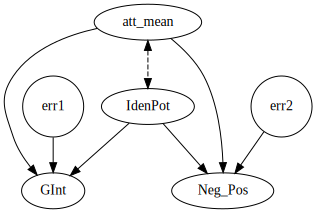

In [39]:
semplot_wth_estimates(m, "pd.png", plot_covs =True)

# Il aurait été bien que les termes d'erreurs

### Evaluate solution
- Indices d'ajustement : **SRMR**, RMSEA, CFI, X2, **correlation residuals, covariance residuals std**
- Paramètres : B, pval, **R2, % de variance expliquée /non-expliquée**


- SPSS: indices de modification

In [40]:
# Indice d'ajustements
stats = semopy.calc_stats(m)
print(stats.T)

                     Value
DoF               3.000000
DoF Baseline      8.000000
chi2              9.285581
chi2 p-value      0.025725
chi2 Baseline  1645.972885
CFI               0.996163
GFI               0.994359
AGFI              0.984956
NFI               0.994359
TLI               0.989767
RMSEA             0.035304
AIC              13.988959
BIC              51.983131
LogLik            0.005521


In [41]:
# paramètres
results = m.inspect(std_est = True)
results

,lval,op,rval,Estimate,Est. Std,Std. Err,z-value,p-value
0,Neg_Pos,~,IdenPot,0.242236,0.172648,0.031900,7.593517,3.108624e-14
1,Neg_Pos,~,att_mean,-0.520308,-0.504154,0.023465,-22.174105,0.000000e+00
2,GInt,~,IdenPot,0.392513,0.275060,0.037788,10.387354,0.000000e+00
3,GInt,~,att_mean,-0.178526,-0.170081,0.027795,-6.422944,1.336637e-10
4,IdenPot,~~,att_mean,-0.537113,-0.531984,0.015583,-34.467658,0.000000e+00
5,Neg_Pos,~~,Neg_Pos,0.911417,0.623412,0.031428,29.000000,0.000000e+00
6,GInt,~~,GInt,1.278863,0.845639,0.044099,29.000000,0.000000e+00


In [70]:
# % de variance non-expliquée = r2
# % de variance expliquée = 1 - % de variance non-expliquée
# R2 : beta std au carré??
# Neg_pos non-expliqué = terme d'erreur std  (Est. Std)

Gint_not_explained = results["Est. Std"][6]
Gint_explained = (1- Gint_not_explained)*100

Negpos_not_explained =results["Est. Std"][5]
Negpos_explained = (1- Negpos_not_explained)*100

print ("The model explains {}% of neg_pos (endogeneous) and {}% of GInt (endogeneous).".format(Negpos_explained, Gint_explained))

The model explains 37.658761826527446% of neg_pos (endogeneous) and 15.43606778927944% of GInt (endogeneous).


In [618]:
parameter = m.parameters  ### b = beta ; c = covariance

#for par in parameter.keys():
#    print("\n" + par)
#    print(parameter[par])

In [43]:
dict_matrix = m.inspect("mx", std_est = True)
for key in dict_matrix.keys():
    print("\n" + key)
    print(pd.DataFrame(dict_matrix[key]))
    
# lambda: estimates bêta
# Psi: estimates covariance
# Theta : esimates termes erreurs


Beta
          IdenPot  att_mean
IdenPot       0.0       0.0
att_mean      0.0       0.0

Lambda
           IdenPot  att_mean
GInt      0.392513 -0.178526
Neg_Pos   0.242236 -0.520308
IdenPot   1.000000  0.000000
att_mean  0.000000  1.000000

Psi
           IdenPot  att_mean
IdenPot   0.742652 -0.537113
att_mean -0.537113  1.372612

Theta
              GInt   Neg_Pos  IdenPot  att_mean
GInt      1.278863  0.000000      0.0       0.0
Neg_Pos   0.000000  0.911417      0.0       0.0
IdenPot   0.000000  0.000000      0.0       0.0
att_mean  0.000000  0.000000      0.0       0.0


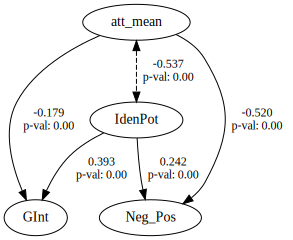

In [44]:
g_model = semplot_with_estimates(m, "pd.png", plot_covs = True)
g_model

#### Covariances résiduelles

In [51]:
# matrix covariance finale
mx_cov_final = m.mx_cov
print(" Matrix covariance finale : \n" +  str(mx_cov_final))

# sur AMOS =0.331069 , ici c'est plutôt =0.41114705  (GInt, Neg_Pos) -> pourquoi cette discordance...

 Matrix covariance finale : 
[[ 1.51212197  0.41114705  0.38751528 -0.45600138]
 [ 0.41114705  1.46140926  0.45926819 -0.84414728]
 [ 0.38751528  0.45926819  0.74265238 -0.53711286]
 [-0.45600138 -0.84414728 -0.53711286  1.37261192]]


In [72]:
# matrix residual covariance
mx_res_cov = (mx_cov_initial - mx_cov_final).abs()
print(" Matrix covariances résiduelles : \n \n" +  str(mx_res_cov))


 Matrix covariances résiduelles : 
 
                  GInt       Neg_Pos       IdenPot      att_mean
GInt      1.287859e-14  0.000000e+00  3.330669e-15  4.440892e-16
Neg_Pos   0.000000e+00  5.107026e-15  3.330669e-15  4.329870e-15
IdenPot   3.330669e-15  3.330669e-15  6.550316e-15  5.107026e-15
att_mean  4.440892e-16  4.329870e-15  5.107026e-15  2.886580e-15


In [73]:
# matrix standard residual covariances
dim = 4
cov_1d = np.array(mx_res_cov).flatten()

# std residuals
std_cov_1d = np.std(cov_1d)
mx_std = [[std_cov_1d]*dim]*dim

# mean residuals
mean_cov_1d = np.mean(cov_1d)
mx_mean = [[mean_cov_1d]*dim]*dim

std_res_cov = (mx_res_cov - mx_mean).abs()/ mx_std
print(" Matrix covariances résiduelles std : \n \n" +  str(std_res_cov))

 Matrix covariances résiduelles std : 
 
              GInt   Neg_Pos   IdenPot  att_mean
GInt      2.983130  1.240127  0.147905  1.094497
Neg_Pos   1.240127  0.434613  0.147905  0.179761
IdenPot   0.147905  0.147905  0.907909  0.434613
att_mean  1.094497  0.179761  0.434613  0.293535


In [448]:
# Devrait être < que 2: pass for all values. Ici seulement GInt, GInt est > 2. On observe des discordances avec amos, mais j'ai l'impression que c'est uniquement une question de précision. + le fait que plus haut on obtiens 0,41 au lieu de 0,33. 

In [88]:
# matrix of residuals correlation

# std for each variable
std_variables = np.array(data.std(axis = 0))

# recover correlation matrix from covariance matrix
def corrMat(data): 
    rows, cols = data.shape 
    corr_mat = np.zeros((cols, cols)) 
  
    for i in range(cols): 
        for j in range(cols): 
  
            x, y = data[:, i], data[:, j] 
            # not here that we are just normalizing the covariance matrix 
            corr_mat[i][j] = data[i][j] / (std_variables[i] * std_variables[j]) 
  
    return corr_mat 


#test to see if we get initial correlation matrix from covariance matrix
mx_cor_initial = corrMat(np.array(mx_cov_initial_npy))
mx_cor_initial

print("This is the recovered initial correlation matrix. \n \n" + str(mx_cor_initial))

This is the recovered initial correlation matrix. 
 
[[ 1.          0.27657814  0.3656812  -0.31651833]
 [ 0.27657814  1.          0.44084676 -0.59601668]
 [ 0.3656812   0.44084676  1.         -0.53198438]
 [-0.31651833 -0.59601668 -0.53198438  1.        ]]


In [95]:
# matrice de corrélations finales 
mx_cor_final = corrMat(np.array(mx_cov_final))
mx_cor_final

print("Matrice des corrélations finales: \n \n" + str(mx_cor_final))

# precision is not the same as in Amos


Matrice des corrélations finales: 
 
[[ 0.99940547  0.2764137   0.36546379 -0.31633015]
 [ 0.2764137   0.99940547  0.44058466 -0.59566233]
 [ 0.36546379  0.44058466  0.99940547 -0.5316681 ]
 [-0.31633015 -0.59566233 -0.5316681   0.99940547]]


In [118]:
# As precision was not exactly the same, I copied the matrix from Amos to get coherent residuals
mx_cor_final_amos = np.reshape([1, 0.22271, 0.365681, -0.316518, 0.22271, 1, 0.440847, -0.596017, 0.365681,0.440847 , 1, -0.531984, -0.316518, -0.596017, -0.531984 , 1], (4,4))
mx_cor_final_amos

array([[ 1.      ,  0.22271 ,  0.365681, -0.316518],
       [ 0.22271 ,  1.      ,  0.440847, -0.596017],
       [ 0.365681,  0.440847,  1.      , -0.531984],
       [-0.316518, -0.596017, -0.531984,  1.      ]])

In [135]:
# matrice de corrélations des résiduelles
# recovering correlation residuals with the function corrMat

print ("Recovered correlation matrix residuals from residual covariance using corrMat function \n \n" + str(np.array(mx_res_cov)))

Recovered correlation matrix residuals from residual covariance using corrMat function 
 
[[1.28785871e-14 0.00000000e+00 3.33066907e-15 4.44089210e-16]
 [0.00000000e+00 5.10702591e-15 3.33066907e-15 4.32986980e-15]
 [3.33066907e-15 3.33066907e-15 6.55031585e-15 5.10702591e-15]
 [4.44089210e-16 4.32986980e-15 5.10702591e-15 2.88657986e-15]]


In [129]:
mx_res_cor_amos = mx_cor_initial- mx_cor_final_amos

print ("Recovered correlation matrix residuals using formula and amos implied correlation matrix \n \n" + str(mx_res_cor_amos))

Recovered correlation matrix residuals using formula and amos implied correlation matrix 
 
[[ 8.43769499e-15  5.38681358e-02  1.98369078e-07 -3.26298110e-07]
 [ 5.38681358e-02  3.33066907e-15 -2.39334883e-07  3.17446030e-07]
 [ 1.98369078e-07 -2.39334883e-07  8.88178420e-15 -3.80115259e-07]
 [-3.26298110e-07  3.17446030e-07 -3.80115259e-07  2.44249065e-15]]


In [131]:
#m.last_result.fun : not sure what this is but was used a lot to compute various fit indices
m.obj_mlw(m.param_vals)

0.00552055962621778

#### Compute SRMR

In [149]:
# SRMR 
srmr = np.mean(pow(np.array(mx_res_cov),2))
srmr_squared = np.sqrt(srmr)
print("SRMR = " + str(srmr_squared))


# SRMR AMOS
srmr_amos = np.mean(pow(mx_res_cor_amos,2))
srmr_squared_amos = np.sqrt(srmr_amos)
print("SRMR = " + str(srmr_squared_amos))

SRMR = 4.858018684455751e-15
SRMR = 0.019045262042815578


### Alternative model

- Différence X2
- Comparer ajustements
- Vérifier la force du lien ajouté

In [160]:
# Alternative model
# specify model : add coariance btw endogenous variables

m2 = '''
Neg_Pos ~ IdenPot + att_mean
GInt ~ IdenPot + att_mean
IdenPot ~~ att_mean
GInt ~~ Neg_Pos
'''

In [161]:
m2 = semopy.Model(m2) 
res = m2.fit(data) #, obj = "FIML")# specifies maximum likelihood
print(res)

Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 0.000
Number of iterations: 13
Params: 0.242 -0.520 0.393 -0.179 -0.537 0.080 1.279 0.911


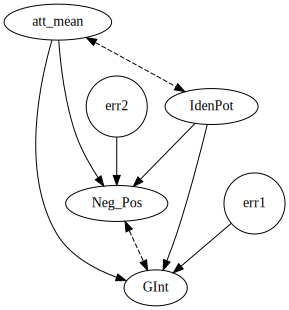

In [162]:
semplot_wth_estimates(m2, "model2.png", plot_covs =True)

In [163]:
# Indice d'ajustements
stats = semopy.calc_stats(m2)
print(stats.T)

                      Value
DoF            2.000000e+00
DoF Baseline   8.000000e+00
chi2           9.684057e-05
chi2 p-value   9.999516e-01
chi2 Baseline  1.645973e+03
CFI            1.001221e+00
GFI            9.999999e-01
AGFI           9.999998e-01
NFI            9.999999e-01
TLI            1.004884e+00
RMSEA          0.000000e+00
AIC            1.600000e+01
BIC            5.942191e+01
LogLik         5.757466e-08


In [164]:
# Pourquoi chi-carré pas le même ... AMOS = 0,000000003

In [165]:
# paramètres
results = m2.inspect(std_est = True)
results

,lval,op,rval,Estimate,Est. Std,Std. Err,z-value,p-value
0,Neg_Pos,~,IdenPot,0.242087,0.172579,0.031896,7.589794,3.197442e-14
1,Neg_Pos,~,att_mean,-0.520151,-0.504110,0.023462,-22.170127,0.000000e+00
2,GInt,~,IdenPot,0.392719,0.275202,0.037784,10.393805,0.000000e+00
3,GInt,~,att_mean,-0.178642,-0.170190,0.027792,-6.427712,1.295388e-10
4,IdenPot,~~,att_mean,-0.537113,-0.531984,0.015583,-34.467658,0.000000e+00
5,GInt,~~,Neg_Pos,0.080036,0.053837,0.026391,3.032707,2.423711e-03
6,GInt,~~,GInt,1.278617,0.845466,0.044090,29.000000,0.000000e+00
7,Neg_Pos,~~,Neg_Pos,0.911193,0.623526,0.031420,29.000000,0.000000e+00


In [166]:
Gint_not_explained = results["Est. Std"][6]
Gint_explained = (1- Gint_not_explained)*100

Negpos_not_explained =results["Est. Std"][5]
Negpos_explained = (1- Negpos_not_explained)*100

print ("The model explains {}% of neg_pos (endogeneous) and {}% of GInt (endogeneous).".format(Negpos_explained, Gint_explained))

The model explains 94.61626734201957% of neg_pos (endogeneous) and 15.453386343296305% of GInt (endogeneous).


In [167]:
dict_matrix = m2.inspect("mx", std_est = True)
for key in dict_matrix.keys():
    print("\n" + key)
    print(pd.DataFrame(dict_matrix[key]))


Beta
          IdenPot  att_mean
IdenPot       0.0       0.0
att_mean      0.0       0.0

Lambda
           IdenPot  att_mean
GInt      0.392719 -0.178642
Neg_Pos   0.242087 -0.520151
IdenPot   1.000000  0.000000
att_mean  0.000000  1.000000

Psi
           IdenPot  att_mean
IdenPot   0.742652 -0.537113
att_mean -0.537113  1.372612

Theta
              GInt   Neg_Pos  IdenPot  att_mean
GInt      1.278617  0.080036      0.0       0.0
Neg_Pos   0.080036  0.911193      0.0       0.0
IdenPot   0.000000  0.000000      0.0       0.0
att_mean  0.000000  0.000000      0.0       0.0


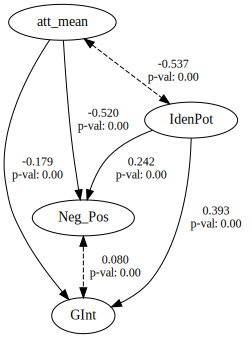

In [168]:
g_model = semplot_with_estimates(m2, "pd.png", plot_covs = True)
g_model

In [176]:
m2.mx_cov

array([[ 1.51212197,  0.41114705,  0.38751528, -0.45600138],
       [ 0.41114705,  1.46140926,  0.45926819, -0.84414728],
       [ 0.38751528,  0.45926819,  0.74265238, -0.53711286],
       [-0.45600138, -0.84414728, -0.53711286,  1.37261192]])

In [177]:
# mx covariance final
m2_mx_cov_final = m2.mx_cov

# matrix residual covariance
m2_mx_res_cov = (mx_cov_initial - m2_mx_cov_final).abs()
print ("Matrix covariance residuals")
pd.DataFrame(m2_mx_res_cov, columns =data.columns, index =data.columns)

Matrix covariance residuals


,GInt,Neg_Pos,IdenPot,att_mean
GInt,1.287859e-14,0.000000e+00,3.330669e-15,4.440892e-16
Neg_Pos,0.000000e+00,5.107026e-15,3.330669e-15,4.329870e-15
IdenPot,3.330669e-15,3.330669e-15,6.550316e-15,5.107026e-15
att_mean,4.440892e-16,4.329870e-15,5.107026e-15,2.886580e-15


In [178]:
m2_cov_1d= np.array(m2_mx_res_cov).flatten()
m2_cov_1d

dim = 4

# std cov residuals
m2_std_cov_1d = np.std(m2_cov_1d)
m2_mx_std = [[m2_std_cov_1d]*dim]*dim

# std mean residuals
m2_mean_cov_1d = np.mean(m2_cov_1d)
m2_mx_mean = [[m2_mean_cov_1d]*dim]*dim

print("Matrix covariance residuals std")
m2_std_res_cov = (m2_mx_res_cov - m2_mx_mean).abs()/ m2_mx_std
m2_std_res_cov

Matrix covariance residuals std


,GInt,Neg_Pos,IdenPot,att_mean
GInt,2.983130,1.240127,0.147905,1.094497
Neg_Pos,1.240127,0.434613,0.147905,0.179761
IdenPot,0.147905,0.147905,0.907909,0.434613
att_mean,1.094497,0.179761,0.434613,0.293535


In [180]:
print("Matrice residual correlation recovered from covariance residuals with function corrMat")
corrMat(np.array(m2_mx_res_cov))

Matrice residual correlation recovered from covariance residuals with function corrMat


array([[8.51183346e-15, 0.00000000e+00, 3.14113793e-15, 3.08066623e-16],
       [0.00000000e+00, 3.49251218e-15, 3.19517384e-15, 3.05532032e-15],
       [3.14113793e-15, 3.19517384e-15, 8.81492025e-15, 5.05525552e-15],
       [3.08066623e-16, 3.05532032e-15, 5.05525552e-15, 2.10173295e-15]])

In [183]:
print("Matrice residual correlation recovered from formula and AMOS implied correlation matrix")

mx_cor_final_amos = np.reshape([1, 0.276578453, 0.365681202, -0.316518326, 0.276578453, 1, 0.440847012, -0.596017043, 0.365681202,0.440847012 , 1, -0.53198438, -0.316518326, -0.596017043, -0.53198438 , 1], (4,4))
mx_cor_final_amos

Matrice residual correlation recovered from formula and AMOS implied correlation matrix


array([[ 1.        ,  0.27657845,  0.3656812 , -0.31651833],
       [ 0.27657845,  1.        ,  0.44084701, -0.59601704],
       [ 0.3656812 ,  0.44084701,  1.        , -0.53198438],
       [-0.31651833, -0.59601704, -0.53198438,  1.        ]])

In [190]:
m2_mx_cor_res = mx_cor_initial - mx_cor_final_amos
m2_mx_cor_res

array([[ 8.43769499e-15, -3.17244363e-07, -3.63092234e-09,
        -2.98109926e-10],
       [-3.17244363e-07,  3.33066907e-15, -2.51334883e-07,
         3.60446030e-07],
       [-3.63092234e-09, -2.51334883e-07,  8.88178420e-15,
        -1.15259358e-10],
       [-2.98109926e-10,  3.60446030e-07, -1.15259358e-10,
         2.44249065e-15]])

In [200]:
srmr = np.mean(pow(np.array(m2_mx_res_cov),2))
srmr_squared = np.sqrt(srmr)
srmr_squared


srmr = np.mean(pow(np.array(m2_mx_cor_res),2))
srmr_squared = np.sqrt(srmr)
srmr_squared

1.9162066541746887e-07

In [ ]:
# compare chi-carré 

# model1- model2
# 

In [44]:
# matrice de corrélation des résiduelles
df_T1.columns

Index(['Gender', 'Age', 'life_cond', 'left_right', 'change_trad', 'Freqnow',
       'Userstatus', 'Legal', 'Illegal', 'Quantity', 'Frequency', 'Neg_Pos',
       'AffectPerso', 'Cat', 'Moi_Pot', 'GCat', 'Can_Pot', 'Qc_Pot',
       'SuiviPot', 'Comp', 'GComp', 'IdenPot', 'GIdenPot', 'Int', 'GInt',
       'UserBin', 'att_mean', 'perc_soc', 'clar_co', 'need', 'percep'],
      dtype='object')

In [45]:
#Create dataframe with the variables of interest
#Gender and Age only for the demographical data
df_model = df_T1.filter(items = ['Gender','Age','UserBin','IdenPot','Neg_Pos', 'att_mean'])

In [46]:
#Transform Gender into categorical variable
df_model['Gender'] = df_model['Gender'].astype("category")

<h3><b>Compute Cronbach's Alpha</b></h3>

<h3><b>Descriptive Stats</b></h3>
Including skewness and kurtosis

In [47]:
def add_skew_kurt_missing(dataframe = None):
    des1 = dataframe.describe(include='all')
    des2 = dataframe.isnull().sum().to_frame(name = 'missing').T
    des3 = dataframe.skew(axis=0,skipna=True).to_frame(name = 'skewness').T
    des4 = dataframe.kurtosis(axis=0,skipna=True).to_frame(name = 'kurtosis').T

    return pd.concat([des1, des2, des3, des4])

In [48]:
add_skew_kurt_missing(dataframe=df_model)

,Gender,Age,UserBin,IdenPot,Neg_Pos,att_mean
count,1657.0,1657.000000,1657.0,1657.000000,1657.000000,1657.000000
unique,2.0,NaN,2.0,NaN,NaN,NaN
top,1.0,NaN,0.0,NaN,NaN,NaN
freq,900.0,NaN,965.0,NaN,NaN,NaN
mean,NaN,50.905250,NaN,0.657614,1.786361,2.182257
std,NaN,15.376517,NaN,0.861823,1.206957,1.166972
min,NaN,18.000000,NaN,0.000000,0.000000,0.000000
25%,NaN,38.000000,NaN,0.000000,1.000000,1.333333
50%,NaN,52.000000,NaN,0.333333,2.000000,2.000000
75%,NaN,64.000000,NaN,1.000000,3.000000,3.000000


In [49]:
df_model = df_model.filter(items = ['UserBin','Neg_Pos','att_mean','IdenPot'])

<h3><b>Z scores (univariate outliers)</b></h3>

In [50]:
#Create an empty dataframe for zscores
df_zscores = pd.DataFrame(columns = df_model.columns)
#Calculate z scores(univariate outliers) for all variables
i=0
while i < len(df_model.columns):
    if df_model.columns[i] == df_zscores.columns[i]:
        df_zscores[df_zscores.columns[i]] = stats.zscore(df_model[df_model.columns[i]], nan_policy='omit')
        i+=1
    else:
        print('error')
        break

df_zscores.head(5)

,UserBin,Neg_Pos,att_mean,IdenPot
0,-0.846817,-1.48050,-0.727678,-0.763281
1,-0.846817,0.17706,0.986676,-0.763281
2,-0.846817,0.17706,-0.441952,-0.763281
3,1.180893,-0.65172,-0.727678,-0.763281
4,-0.846817,0.17706,-0.156227,1.558082


In [51]:
for i in range(len(df_zscores.columns)):
    v_min = df_zscores[df_zscores.columns[i]].min(skipna = True)
    v_max = df_zscores[df_zscores.columns[i]].max()
    print(df_zscores.columns[i], ": ", "min = ", v_min, " max = ", v_max)

UserBin :  min =  -0.8468166540614649  max =  1.180893166429644
Neg_Pos :  min =  -1.4804997530142  max =  1.834619288532461
att_mean :  min =  -1.870580944946523  max =  1.5581277118857653
IdenPot :  min =  -0.7632805792371932  max =  3.8794453423144577


<h3><b>Multivariate outliers</b></h3>
<br> Mahalanobis Distance: D^2 = (x-m)^T . C^(-1) . (x-m)
<br>
<br> D^2 := Square of the Mahalanobis distance
<br> x := vector of the observations
<br> m := vector of mean values of IV
<br> C^(-1) := inverse covariance matrix of IV
<br> . := dot product

In [52]:
#Calculate multivariate outliers (mahalanobis distance)
#https://www.machinelearningplus.com/statistics/mahalanobis-distance/

def mahalanobis_outliers(x=None, data=None, cov=None, dfreed=None, sign = None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov=np.cov(data.values.T)
    inv_covmat = scipy.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    data['mahal_square'] = np.power(md, 2)

    chi_critic = stats.chi2.ppf((1-sign), df = dfreed)

    ls_multioutliers = []

    for i in range (625):
        try:
            if data['mahal_square'][i] > chi_critic:
                ls_multioutliers.append(i+1)
        except:
            continue
    
    return data['mahal_square'], ls_multioutliers, chi_critic


col_mahal, ls_multiout, chi = mahalanobis_outliers(x = df_model.select_dtypes(exclude = 'category'), data = df_model.select_dtypes(exclude = 'category'), dfreed = len(df_model.select_dtypes(exclude = 'category').columns) - 1, sign = 0.001)
print('participants outliers: ', ls_multiout, '\nChi2 critique: ', chi)

participants outliers:  [16, 203, 287, 292, 575] 
Chi2 critique:  13.815510557964274


<h3>Bivariate relationship linearity</h3>

In [54]:
def residual_plot(dataframe = None, VI = None, VD = None):
    model = sm.OLS(dataframe[VD], sm.add_constant(dataframe[VI])).fit()
    ypred = model.predict()
    standardized_yresid = preprocessing.scale(model.resid)
    standardized_ypred = preprocessing.scale(ypred)
    plt.scatter(standardized_ypred, standardized_yresid)
    plt.plot([min(standardized_ypred),max(standardized_ypred)],[0,0])
    plt.suptitle('VD : {} - VI : {}'.format(VD, VI))
    plt.xlabel('Régression Valeur prédite standardisée')
    plt.ylabel('Régression Résiduel standardisé')

    return standardized_yresid

In [59]:
def residual_hist(stand_res = None, VD = None):
    _, bins, _ = plt.hist(stand_res, bins = 15, range=(-3,1), density = 1, alpha = 0.5)
    mu, sigma = stats.norm.fit(stand_res)
    best_fit_line = stats.norm.pdf(bins, mu, sigma)
    plt.suptitle('Variable dépendante : ' + VD)
    plt.xlabel('Régression Résiduel standardisé')
    plt.ylabel('Fréquence')
    plt.plot(bins, best_fit_line)

<b>IdentifyPot and Neg_Pos</b>

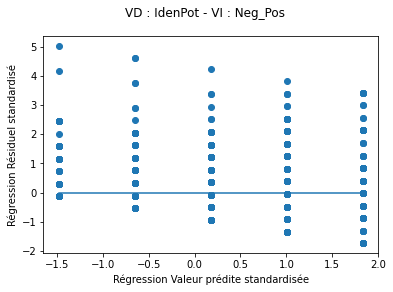

In [57]:
res_1 = residual_plot(dataframe = df_model, VI = 'Neg_Pos', VD = 'IdenPot')

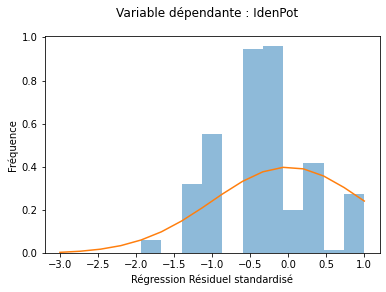

In [60]:
residual_hist(stand_res = res_1, VD = 'IdenPot')

<b>IdentifyPot and average Attitude</b>

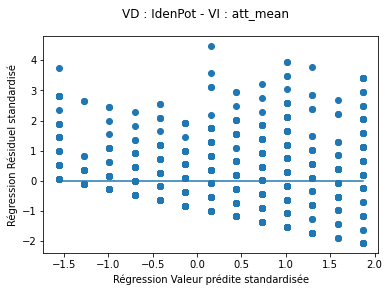

In [61]:
res_2 = residual_plot(dataframe = df_model, VI = 'att_mean', VD = 'IdenPot')

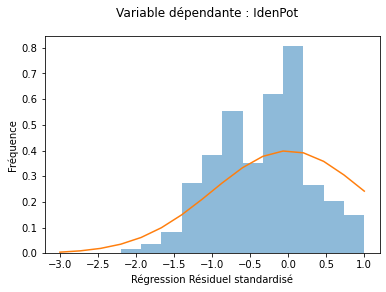

In [62]:
residual_hist(stand_res = res_2, VD = 'IdenPot')

<b>Neg_Pos and average Attitude</b>

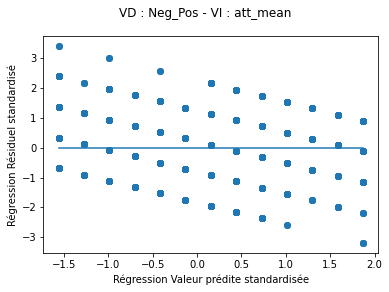

In [63]:
res_3 = residual_plot(dataframe = df_model, VI = 'att_mean', VD = 'Neg_Pos')

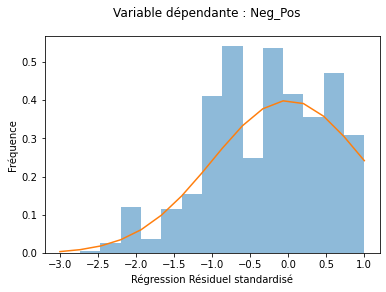

In [64]:
residual_hist(stand_res = res_3, VD = 'Neg_Pos')